In [ ]:
# code block to import all packages used throughout

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [83]:
# load in and set up data

X_train = pd.read_csv('data/train.csv', index_col = 'Id')
X_test = pd.read_csv('data/test.csv', index_col = 'Id')

# target values
Y_train = X_train['SalePrice']
# all x values - avoid using due to possible data leakage
X_full = pd.concat([X_train, X_test])

# data types and size of data
print(f"Data types: {X_train.dtypes.unique()} Test set shape: {X_train.shape}, Train set shape: {X_train.shape}")

Data types: [dtype('int64') dtype('O') dtype('float64')] Test set shape: (1460, 80), Train set shape: (1460, 80)


In [84]:
# quick look at data
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [85]:
# Use the train set for most analysis to prevent data leakage

# Identify columns in X_train that contain missing values
null_cols = X_train.columns[X_train.isnull().any()]

# Print the count of missing values in those columns
X_train[null_cols].isnull().sum()


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [86]:
cat_cols = X_train.select_dtypes(include='O').columns.tolist() #catagorical
num_cols = [x for x in X_train.columns if x not in cat_cols and x != 'SalePrice'] # numeric

print(f"Numeric columns: {num_cols},\nCatagorical columns: {cat_cols}")

Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
Catagorical columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', '

In [87]:
[x for x in X_train.columns if x not in cat_cols and x not in num_cols]

['SalePrice']

In [88]:
# catagorical null values mean that the house doesn't have this thing (eg garagequal null means no garage)

# numeric nulls
print([x for x in num_cols if x in null_cols])

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [89]:
# fill lot frontage nulls with -1 (doesn't appear) and we will deal with this later
X_train['LotFrontage'] = X_train['LotFrontage'].fillna(-1)
X_test['LotFrontage'] = X_test['LotFrontage'].fillna(-1)

for col in null_cols:
    if col in cat_cols:
        X_train[col] = X_train[col].fillna('None') # always means doesn't apply so keep this by filling with none
        X_test[col] = X_train[col].fillna('None')
    else:
        X_train[col] = X_train[col].fillna(0) # fill numerics with 0, we will return to lot frontage later
        X_test[col] = X_test[col].fillna(0)

X_train.columns[X_train.isna().any()] # check all nulls are filled


Index([], dtype='object')

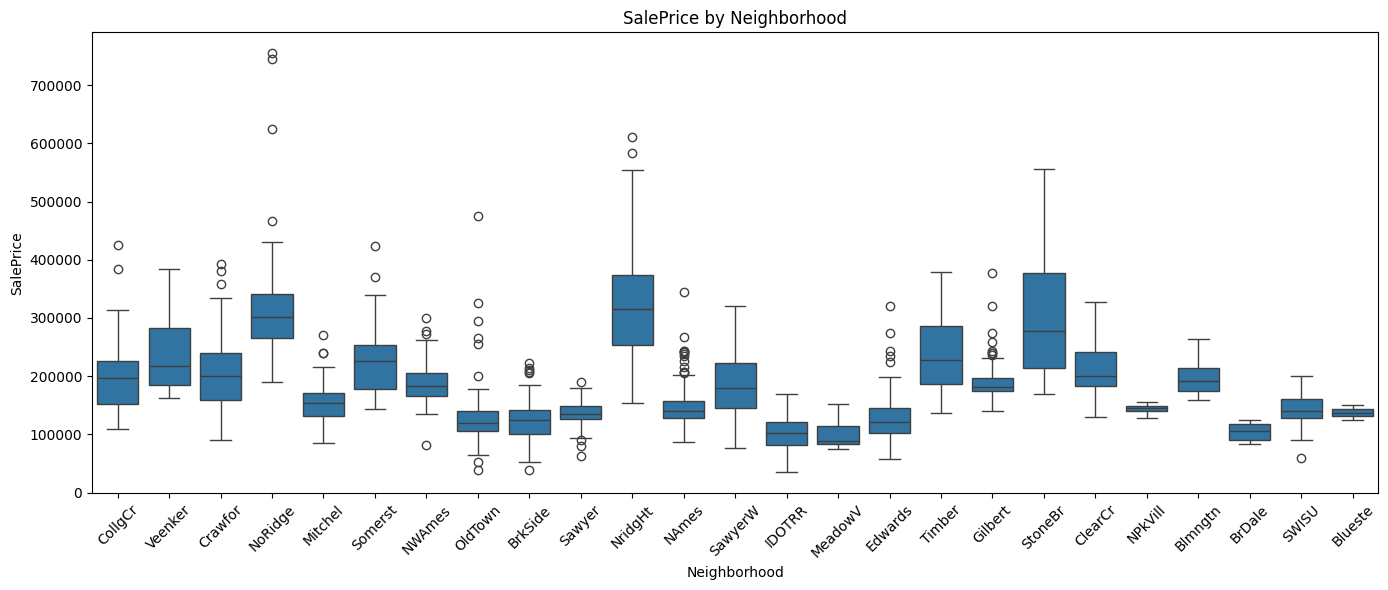

In [90]:
# boxplot of sale price by neighbourhood
plt.figure(figsize=(14, 6))
sns.boxplot(data=X_train, x='Neighborhood', y='SalePrice')
plt.xticks(rotation=45)
plt.title('SalePrice by Neighborhood')
plt.tight_layout()
plt.show()

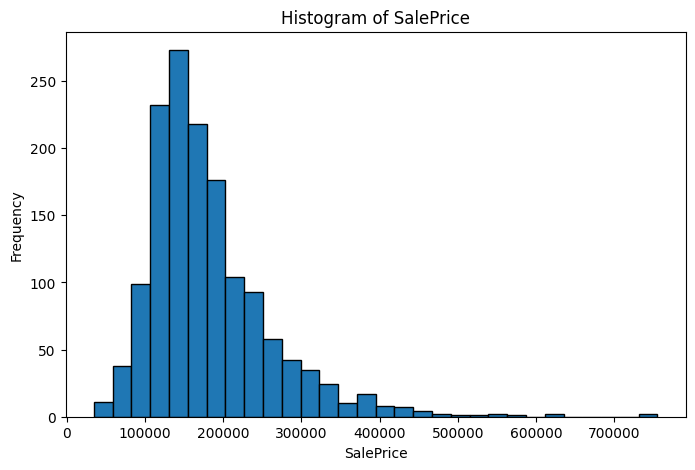

In [91]:
# Note on outliers: removing them can be dangerous as it can remove important information
# We have no reason to believe any of these values have been recorded incorrectly (they are all integers within a suitable range), so we will continue with all data.
X_train.pop('SalePrice')
# SalePrice histogram
plt.figure(figsize=(8, 5))
plt.hist(Y_train, bins=30, edgecolor='black')
plt.title('Histogram of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

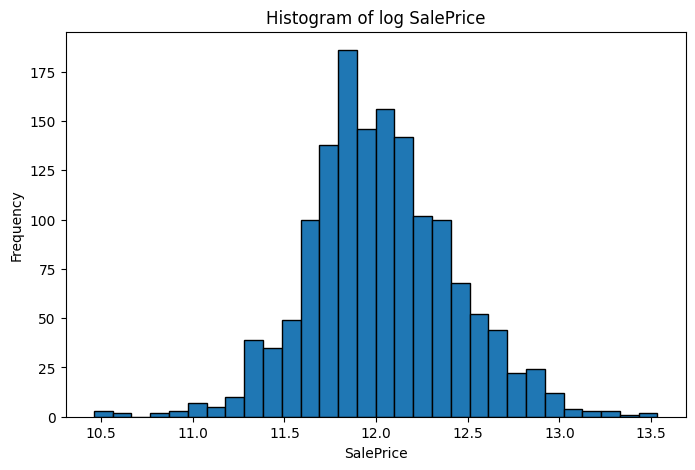

In [92]:
# right-skewed distribution, try a transformation
log_Y_train = np.log(Y_train)
# same histogram code
plt.figure(figsize=(8, 5))
plt.hist(log_Y_train, bins=30, edgecolor='black')
plt.title('Histogram of log SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

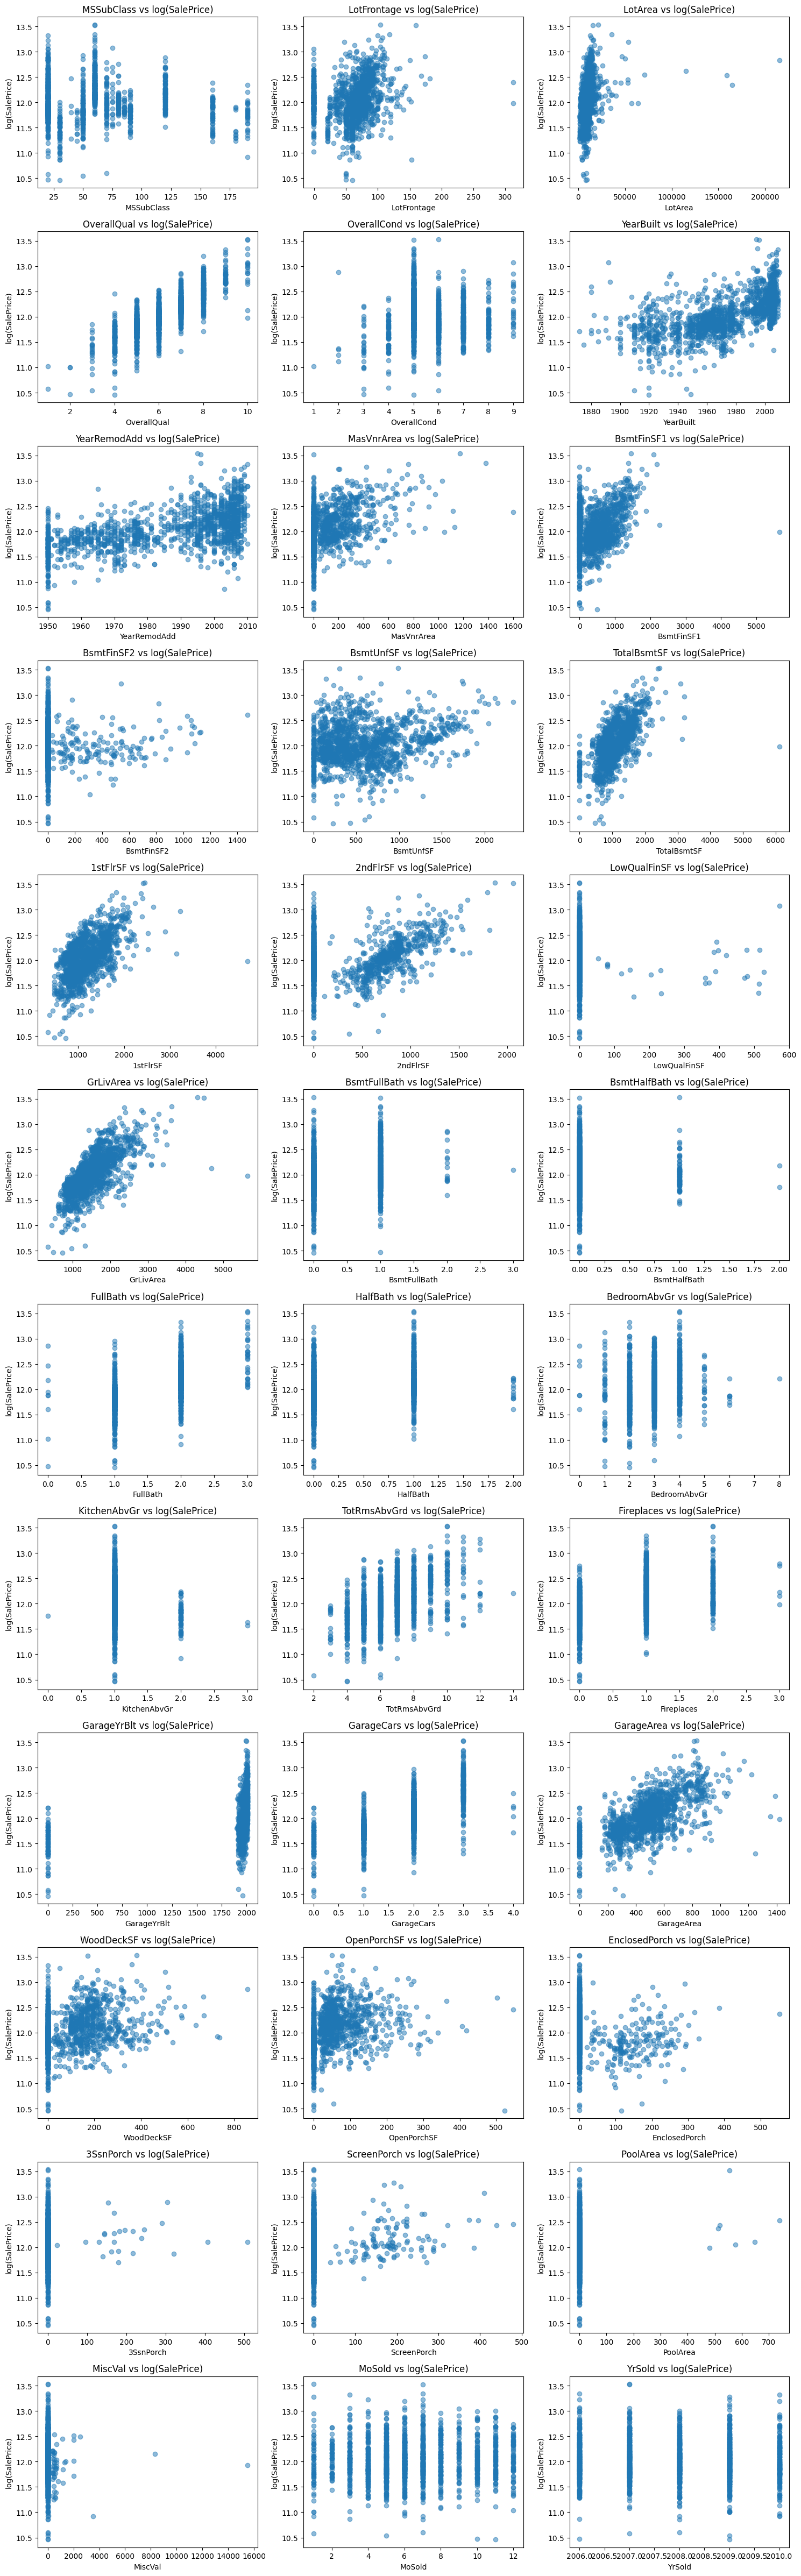

In [93]:
# distribution looks much better, we will use log values.
# scatter plots of numeric columns
n_cols = 3
n_plots = len(num_cols)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()  # flatten 2D axes array into 1D for easy indexing

for i, col in enumerate(num_cols):
    axes[i].scatter(X_train[col], log_Y_train, alpha=0.5)
    axes[i].set_title(f'{col} vs log(SalePrice)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(SalePrice)')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [94]:
# some of the variables are actually categorical
# Combine month and year to make a timestamp column
X_train['Month'] = X_train['MoSold'].astype(str) + '-' + X_train['YrSold'].astype(str)
X_test['Month'] = X_test['MoSold'].astype(str) + '-' + X_test['YrSold'].astype(str)

X_train.drop(['MoSold', 'YrSold'], axis=1, inplace=True)
X_test.drop(['MoSold', 'YrSold'], axis=1, inplace=True)
cat_cols.append('Month')

# update the catagorical columns
cols_to_move = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']
cat_append_cols = [x for x in cols_to_move if x not in ['MoSold', 'YrSold']]
cat_cols.extend(cat_append_cols)
num_cols = [y for y in X_train if y not in cat_cols]

num_cols

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [95]:
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'Month',
 'MSSubClass',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

In [96]:
print(f"intersection: {[x for x in cat_cols if x in num_cols]}, Unaccounted for columns: {[y for y in X_test.columns if y not in cat_cols and y not in num_cols]}")

intersection: [], Unaccounted for columns: []


In [97]:
# update the remaining null values in the test - fill by mode for catagoric and mean for numeric
# some nulls remaining as we only processed the columns where there is a null in the train set
for col in X_test.columns:
    if col in cat_cols:
        mode = X_train[col].mode()
        X_test[col] = X_test[col].fillna(mode[0])
    elif col in num_cols:
        X_test[col] = X_test[col].fillna(X_test[col].mean())


        
X_test.columns[X_test.isna().any()] # check all nulls are filled

Index([], dtype='object')

In [98]:
# need to fill the lot frontage values, na doesn't seem to mean value of 0 as there are 0 values in there
# assume a null house is 'normal' in their neighbourhood, fill by median in neighbourhood

# only update LotFrontage where it's -1 from earlier
lot_train_mask = X_train['LotFrontage'] == -1
# replace with median LotFrontage per Neighborhood
X_train.loc[lot_train_mask, 'LotFrontage'] = (
    X_train.groupby('Neighborhood')['LotFrontage'].transform('median')[lot_train_mask]
)
# same for test set
lot_test_mask = X_test['LotFrontage'] == -1
X_test.loc[lot_test_mask, 'LotFrontage'] = (
    X_test.groupby('Neighborhood')['LotFrontage'].transform('median')[lot_test_mask]
)

X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,Month
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,0,None,None,None,0,WD,Normal,2-2008
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,0,None,None,None,0,WD,Normal,5-2007
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,0,None,None,None,0,WD,Normal,9-2008
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,0,None,None,None,0,WD,Abnorml,2-2006
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,0,None,None,None,0,WD,Normal,12-2008


In [99]:
# find highest correlations
def multicollinearity(matrix):
    threshold_pos = 0.6
    threshold_neg = -0.6
    high_corr_positive = (matrix > threshold_pos) & (matrix < 1.0)
    high_corr_negative = (matrix < threshold_neg) & (matrix > -1.0)
    high_corr_pairs = high_corr_positive | high_corr_negative
    pairs_with_high_corr = [(i, j, matrix.loc[i, j]) for i in high_corr_pairs.columns for j in high_corr_pairs.index if high_corr_pairs.loc[i, j]]

    for pair in pairs_with_high_corr:
        print(f"Features: {pair[0]}, {pair[1]} - Correlation: {pair[2]}")

In [100]:
# run corr matrix on all number columns
not_number_cols = X_full.select_dtypes(include='O').columns.tolist()
number_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix1 = X_train[number_cols].corr()
multicollinearity(corr_matrix1)

Features: OverallQual, GarageCars - Correlation: 0.6006707165907149
Features: BsmtFinSF1, BsmtFullBath - Correlation: 0.6492117535742649
Features: TotalBsmtSF, 1stFlrSF - Correlation: 0.8195299750050339
Features: 1stFlrSF, TotalBsmtSF - Correlation: 0.8195299750050339
Features: 2ndFlrSF, GrLivArea - Correlation: 0.6875010641666033
Features: 2ndFlrSF, HalfBath - Correlation: 0.6097073002717436
Features: 2ndFlrSF, TotRmsAbvGrd - Correlation: 0.6164226354915431
Features: GrLivArea, 2ndFlrSF - Correlation: 0.6875010641666033
Features: GrLivArea, FullBath - Correlation: 0.6300116462511148
Features: GrLivArea, TotRmsAbvGrd - Correlation: 0.8254893743088425
Features: BsmtFullBath, BsmtFinSF1 - Correlation: 0.6492117535742649
Features: FullBath, GrLivArea - Correlation: 0.6300116462511148
Features: HalfBath, 2ndFlrSF - Correlation: 0.6097073002717436
Features: BedroomAbvGr, TotRmsAbvGrd - Correlation: 0.676619935742649
Features: TotRmsAbvGrd, 2ndFlrSF - Correlation: 0.6164226354915431
Features

In [101]:
# simplify features mainly based on common sense and high correlations to avoid overfitting
X_train['TotalLivingArea'] = X_train['1stFlrSF'] + X_train['TotalBsmtSF'] + X_train['2ndFlrSF'] + X_train['GrLivArea']
X_train['GarageSpace'] = (2 * X_train['GarageArea'] / X_train['GarageArea'].mean()  +  X_train['GarageCars']) # measure same thing

# drop the original columns - last two dropped for correlation issues
X_train = X_train.drop(['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageYrBlt'], axis=1)

# test set
X_test['TotalLivingArea'] = X_test['1stFlrSF'] + X_test['TotalBsmtSF'] + X_test['2ndFlrSF'] + X_test['GrLivArea']
X_test['Garage'] = ((2 * X_test['GarageArea'] / X_test['GarageArea'].mean())  +  X_test['GarageCars'])
X_test = X_test.drop(['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageYrBlt'], axis=1)

# Common sense feature combining
X_train['TotalBathrooms'] = (X_train['FullBath'] + (0.5 * X_train['HalfBath']) +
                               X_train['BsmtFullBath'] + (0.5 * X_train['BsmtHalfBath']))

X_train['TotalPorch'] = (X_train['OpenPorchSF'] + X_train['3SsnPorch'] +
                              X_train['EnclosedPorch'] + X_train['ScreenPorch'] +
                              X_train['WoodDeckSF'])

X_test['TotalBathrooms'] = (X_test['FullBath'] + (0.5 * X_test['HalfBath']) +
                               X_test['BsmtFullBath'] + (0.5 * X_test['BsmtHalfBath']))

X_test['TotalPorch'] = (X_test['OpenPorchSF'] + X_test['3SsnPorch'] +
                              X_test['EnclosedPorch'] + X_test['ScreenPorch'] +
                              X_test['WoodDeckSF'])

# drop the original columns
bath_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
porch_cols = ['OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']

X_train.drop(columns=bath_cols + porch_cols, inplace=True)
X_test.drop(columns=bath_cols + porch_cols, inplace=True)

In [102]:
# run corr matrix on all number columns
not_number_cols = X_full.select_dtypes(include=['object']).columns.tolist()
number_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix2 = X_train[number_cols].corr()
multicollinearity(corr_matrix2)

Features: OverallQual, TotalLivingArea - Correlation: 0.6588383554190327
Features: TotalLivingArea, OverallQual - Correlation: 0.6588383554190327
Features: TotalLivingArea, TotalBathrooms - Correlation: 0.6195557658717082
Features: TotalBathrooms, TotalLivingArea - Correlation: 0.6195557658717082


In [103]:
# clearly not worth combining any more, so we stop there
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,Month,TotalLivingArea,GarageSpace,TotalBathrooms,TotalPorch
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,0,WD,Normal,2-2008,4276,4.317222,3.5,61
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,None,None,0,WD,Normal,5-2007,3786,3.945113,2.5,298
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,0,WD,Normal,9-2008,4492,4.570932,3.5,42
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,0,WD,Abnorml,2-2006,4190,5.714702,2.0,307
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,None,None,0,WD,Normal,12-2008,5541,6.535032,3.5,276


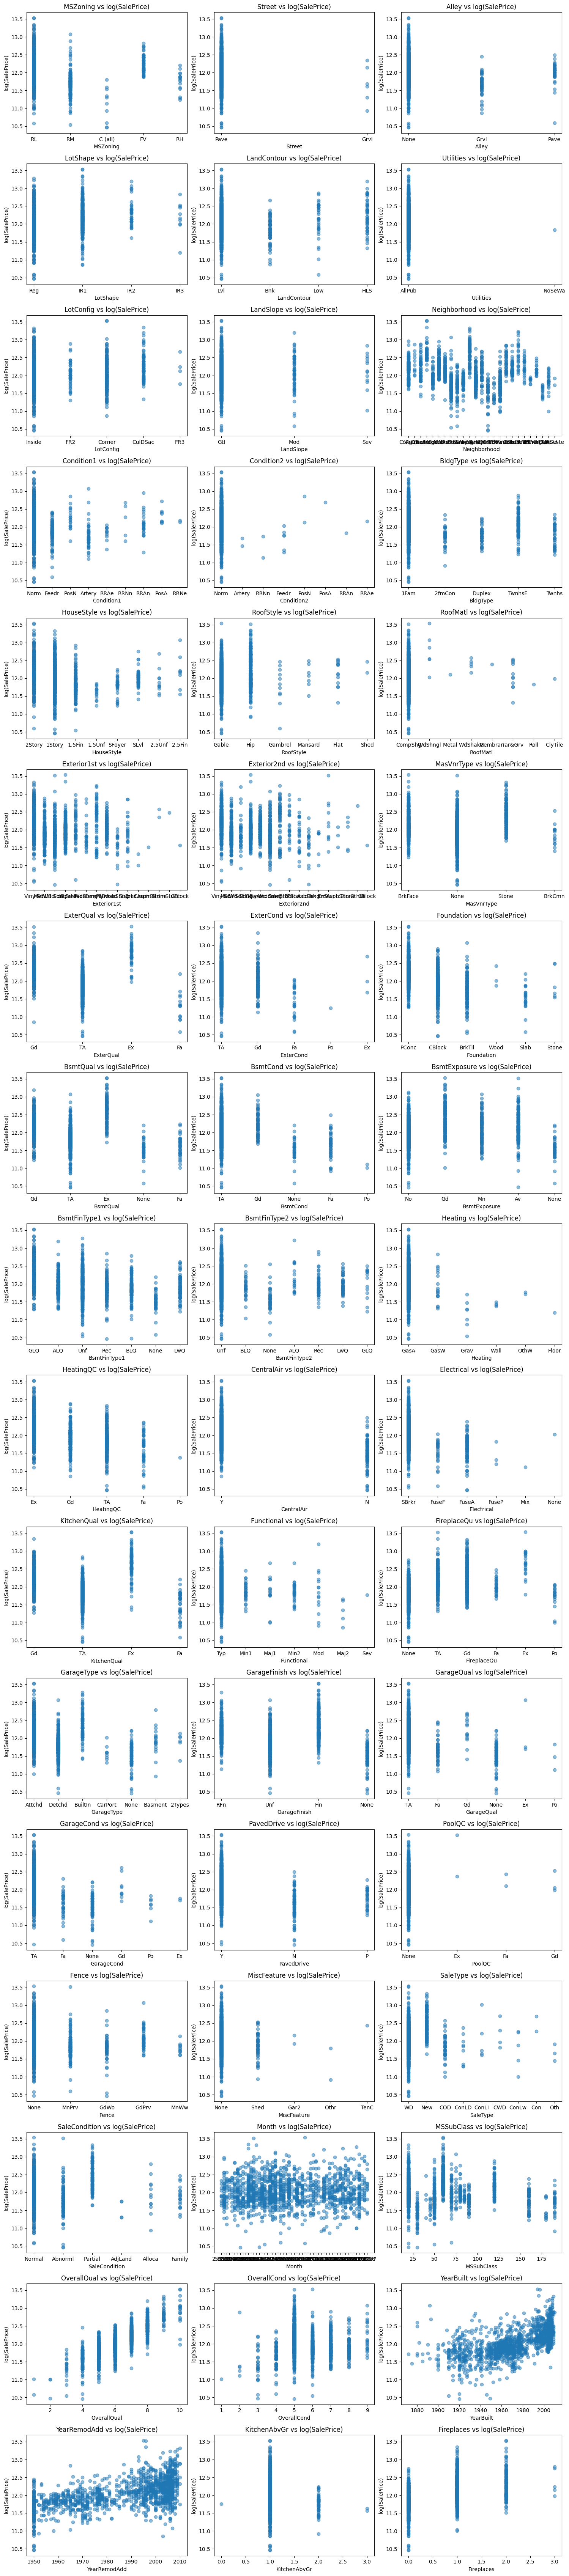

In [104]:
# update catagoric variables
cat_cols = [x for x in cat_cols if x in X_train.columns]

# scatter plots to determine which encoder to use - some will be ordered and others not
n_cols = 3
n_plots = len(cat_cols)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()  # flatten 2D axes array into 1D for easy indexing

for i, col in enumerate(cat_cols):
    axes[i].scatter(X_train[col], log_Y_train, alpha=0.5)
    axes[i].set_title(f'{col} vs log(SalePrice)')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(SalePrice)')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.subplots_adjust(hspace=0.8)
plt.tight_layout()

plt.show()

In [105]:
# From the above plots and common sense we can decide which encoder (label or ordinal) for each variable

# Use ChatGPT to look through the data description and assign the relative maps
# Ordered Catagories
ordinal_cols = [
    "LotShape","LandSlope",
    "ExterQual","ExterCond",
    "BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
    "HeatingQC","KitchenQual","FireplaceQu",
    "GarageFinish","GarageQual","GarageCond",
    "PavedDrive","PoolQC","Fence",
    "Functional","OverallQual","OverallCond"
]

# define the ordered scales - taken from the data description
lot_shape_scale   = ['IR3','IR2','IR1','Reg']
land_slope_scale  = ['Sev','Mod','Gtl']
quality_scale     = ['Po','Fa','TA','Gd','Ex']
exposure_scale    = ['No','Mn','Av','Gd']
bsmt_fin_scale    = ['Unf','LwQ','Rec','BLQ','ALQ','GLQ']
garage_fin_scale  = ['Unf','RFn','Fin']
paved_drive_scale = ['N','P','Y']
pool_scale        = ['Fa','Gd','Ex']
fence_scale       = ['MnWw','GdWo','MnPrv','GdPrv']
functional_scale  = ['Sev','Sal','Maj2','Maj1','Mod','Min2','Min1','Typ']
overall_scale     = [1,2,3,4,5,6,7,8,9,10]


# assign a map between the catagory and the scale
ord_categories = [
    lot_shape_scale,
    land_slope_scale,

    quality_scale,  # ExterQual
    quality_scale,  # ExterCond

    quality_scale,  # BsmtQual
    quality_scale,  # BsmtCond
    exposure_scale, # BsmtExposure
    bsmt_fin_scale, # BsmtFinType1
    bsmt_fin_scale, # BsmtFinType2

    quality_scale,  # HeatingQC
    quality_scale,  # KitchenQual
    quality_scale,  # FireplaceQu

    garage_fin_scale, # GarageFinish
    quality_scale,     # GarageQual
    quality_scale,     # GarageCond

    paved_drive_scale, # PavedDrive
    pool_scale,        # PoolQC
    fence_scale,       # Fence

    functional_scale,  # Functional
    overall_scale,     # OverallQual
    overall_scale      # OverallCond
]

# unordered catagorical variables that need to be encoded
label_cols = [
    "MSSubClass","MSZoning","Street","Alley","LotConfig","LandContour",
    "Utilities","Neighborhood","Condition1","Condition2","BldgType",
    "HouseStyle","RoofStyle","RoofMatl","Exterior1st","Exterior2nd",
    "MasVnrType","Foundation","Heating","CentralAir","Electrical",
    "GarageType","MiscFeature","SaleType","SaleCondition","Month"
]

# use a target encoder for the unordered columns
class SimpleTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing: float = 0.0):
        self.smoothing = smoothing
        self.mappings_ = [] 

    def fit(self, X, y):
        X = np.asarray(X)
        self.mappings_ = []
        prior = np.mean(y)
        for col in range(X.shape[1]):
            vals = X[:, col]
            df = pd.DataFrame({'val': vals, 'y': y})
            stats = df.groupby('val')['y'].agg(['mean','count'])
            smooth = stats['count'] / (stats['count'] + self.smoothing)
            mapping = ((1 - smooth) * prior + smooth * stats['mean']).to_dict()
            self.mappings_.append(mapping)
        return self

    def transform(self, X):
        X = np.asarray(X)
        out = np.zeros_like(X, dtype=float)
        # global mean in case of unseen
        global_mean = np.mean([v for m in self.mappings_ for v in m.values()])
        for col in range(X.shape[1]):
            mapping = self.mappings_[col]
            col_vals = X[:, col]
            out[:, col] = [mapping.get(v, global_mean) for v in col_vals]
        return out

# build the column processor
preprocessor = ColumnTransformer([
    # ordinal, unknowns mapped to –1 (this shouldn't happen as all nulls are filled)
    ("ord", OrdinalEncoder(
        categories=ord_categories,
        dtype=int,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ), ordinal_cols),

    # use mean imputer for the target encoder
    ("mean", Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("tgtenc",  SimpleTargetEncoder(smoothing=0.3))
    ]), label_cols),
], remainder="passthrough")


In [106]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,SaleType,SaleCondition,Month,TotalLivingArea,GarageSpace,TotalBathrooms,TotalPorch
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,None,None,0,WD,Normal,2-2008,4276,4.317222,3.5,61
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,None,None,0,WD,Normal,5-2007,3786,3.945113,2.5,298
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,None,None,0,WD,Normal,9-2008,4492,4.570932,3.5,42
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,None,None,0,WD,Abnorml,2-2006,4190,5.714702,2.0,307
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,None,None,0,WD,Normal,12-2008,5541,6.535032,3.5,276


In [ ]:
# make a function to optimise the xgboost model
def optimize_xgb(X, y, n_trials=100, cv_splits=5, seed=100, n_jobs=6):
    def objective(trial):
        # Sample hyperparameters
        params = {
            # optimise these parameters
            'n_estimators':      trial.suggest_int('n_estimators', 500, 5000),
            'max_depth':         trial.suggest_int('max_depth', 2, 10),
            'learning_rate':     trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'subsample':         trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma':             trial.suggest_float('gamma', 0.0, 5.0),
            'min_child_weight':  trial.suggest_int('min_child_weight', 0, 10),
            'reg_alpha':         trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
            'reg_lambda':        trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
            # fixed parameters
            'objective':         'reg:squarederror',
            'random_state':      seed,
            'verbosity':         0,
            'n_jobs':            n_jobs,
            'scale_pos_weight':  1
        }

        # build pipeline: column transformer, scale everything, xboost model
        model = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler',       StandardScaler()),
            ('regressor',    XGBRegressor(**params))
        ])

        # return the cross-validation score
        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=seed)
        scores = cross_val_score(
            model, X, y,
            scoring='neg_root_mean_squared_error',
            cv=cv,
            n_jobs=1
        )
        return -scores.mean()

    # run the study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # output the results
    print("Best Parameters:", study.best_params)
    print("Best CV RMSE  :", study.best_value)

    # retrain final model on full data with best parameters
    best_params = study.best_params.copy()
    best_params.update({
        'objective':        'reg:squarederror',
        'random_state':     seed,
        'verbosity':        0,
        'n_jobs':           n_jobs,
        'scale_pos_weight': 1
    })

    # make the final pipeline
    final_model = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler',       StandardScaler()),
        ('regressor',    XGBRegressor(**best_params))
    ])
    final_model.fit(X, y)

    return study, final_model

In [ ]:
# do the optimisation - commented out as it takes a long time to run, results are after this cell

# study, xgb_model = optimize_xgb(X_train, log_Y_train, n_trials = 100, cv_splits=5, seed=100,n_jobs=6)

# get the predictions and undo the log transform
y_pred = np.exp(xgb_model.predict(X_test))

Best Parameters: {'n_estimators': 4876, 'max_depth': 6, 'learning_rate': 0.004043450353887623, 'subsample': 0.560075094225553, 'colsample_bytree': 0.5043020157130818, 'gamma': 0.008576389065491715, 'min_child_weight': 0, 'reg_alpha': 3.0195769639151745e-05, 'reg_lambda': 6.781478951247024e-07}

Best CV RMSE  : 0.11873451782151838

In [ ]:
# Alternative approach from first attempt (doesn't take as long to run and still performed fairly well)
# pipe needs to be defined, can use the same pipeline we did

# p_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__max_depth': [4, 5, 6],
    'model__learning_rate': [0.1, 0.05, 0.01],
}

# using cross value scores, search for the optimal parameters

# grid_search = GridSearchCV(pipe, param_grid=p_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
# grid_search.fit(X_train_enc, Y_train)

# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# best_params

# build model with these parameters etc...

In [110]:
# round to nearest integer (as sales prices are always integers) and convert dtype:
int_prices = np.rint(y_pred).astype(int)

# prepare submission
output = pd.DataFrame({
    'Id': X_test.index,
    'SalePrice': int_prices
})

# save to csv ready for upload
output.to_csv('data/submission.csv', index=False)

output.head()

,Id,SalePrice
0,1461,120664
1,1462,159648
2,1463,172433
3,1464,185375
4,1465,179611
